**Monitoring**

key details we need to monitor and debug our Spark Applications. This is done through Spark UI.We will need to monitor our Spark jobs to understand where issues are occuring in them.

Items to monitor

*  JVM
*  OS
*  Cluster


Two important things to monitor

1.	Processes at CPU usage, memory usage, etc
2.	Query execution – Jobs, stages, tasks


**Note:**
cluster monitoring solutions like Ganglia

# Spark Logs

We can add your own debug statements in Azure Databricks Spark jobs

Spark uses log4j internally, and Databricks exposes it for your code. We can write debug/info/warn/error messages


In [ ]:
from pyspark.sql import SparkSession
import logging

In [ ]:
# Get Spark logger
spark = SparkSession.builder.getOrCreate()
log4jLogger = spark._jvm.org.apache.log4j
logger = log4jLogger.LogManager.getLogger(__name__)


In [ ]:
# Log messages
logger.info("This is an info message")
logger.debug("This is a debug message")
logger.warn("This is a warning")
logger.error("This is an error")



Where it appears:
*  Driver logs if run in notebook driver code
*  Executor logs if run inside transformations like map, foreach


In [ ]:
#Example inside an RDD / DataFrame operation
rdd = spark.sparkContext.parallelize([1,2,3,4])
def debug_fn(x):
    logger.info(f"Processing element {x}")
    return x * 2


In [ ]:
rdd2 = rdd.map(debug_fn)
rdd2.collect()

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pyspark/serializers.py", line 460, in dumps
    return cloudpickle.dumps(obj, pickle_protocol)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pyspark/cloudpickle/cloudpickle.py", line 1537, in dumps
    cp.dump(obj)
  File "/usr/local/lib/python3.12/dist-packages/pyspark/cloudpickle/cloudpickle.py", line 1303, in dump
    return super().dump(obj)
           ^^^^^^^^^^^^^^^^^
TypeError: cannot pickle '_thread.RLock' object


PicklingError: Could not serialize object: TypeError: cannot pickle '_thread.RLock' object

The info messages for each element will appear in the executor logs, because the code runs on worker nodes.

**Using Python logging module (driver-only)**

If the code only runs on the driver

In [ ]:
import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("MyLogger")
logger.info("Processing started")


# Spark UI

Spark UI provides a visual way to monitor applications

Every SparkContext running launches a web UI, by default on port 4040, that displays useful information about the application.

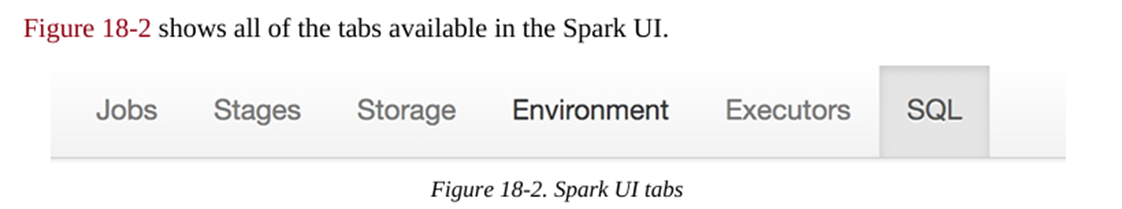

In [ ]:
spark.read\
.option("header", "true")\
.csv("/data/retail-data/all/online-retail-dataset.csv")\
.repartition(2)\
.selectExpr("instr(Description, 'GLASS') >= 1 as is_glass")\
.groupBy("is_glass")\
.count()\
.collect()


AnalysisException: [PATH_NOT_FOUND] Path does not exist: file:/data/retail-data/all/online-retail-dataset.csv. SQLSTATE: 42K03

https://spark.apache.org/docs/latest/monitoring.html#spark-configuration-options

**Spark SQL tab**

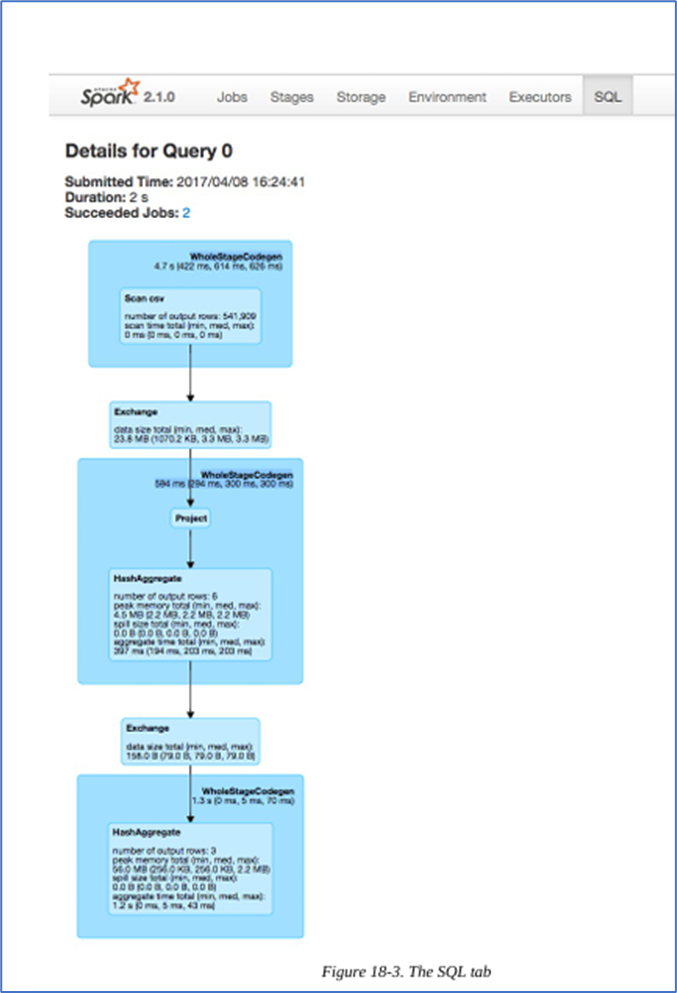

**Observations:**

Submitted Time: 2017/04/08 16:24:41

Duration: 2 s

Succeeded Jobs: 2


**Spark Stages tab**

Directed Acyclic Graph (DAG) of Spark stages.

Each blue box in these tabs represent a stage of Spark

The entire group of these stages represent our Spark job.


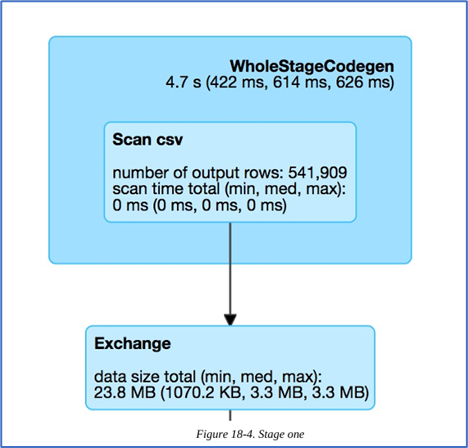

The box  labeled WholeStateCodegen, represents a full scan of the CSV file.

The box below that represents a shuffle that we forced when we called repartition. This turned our original dataset into two partitions.

spark.read.option("header", "true").csv("/data/retail-data/all/online-retail-dataset.csv")\

.repartition(2)


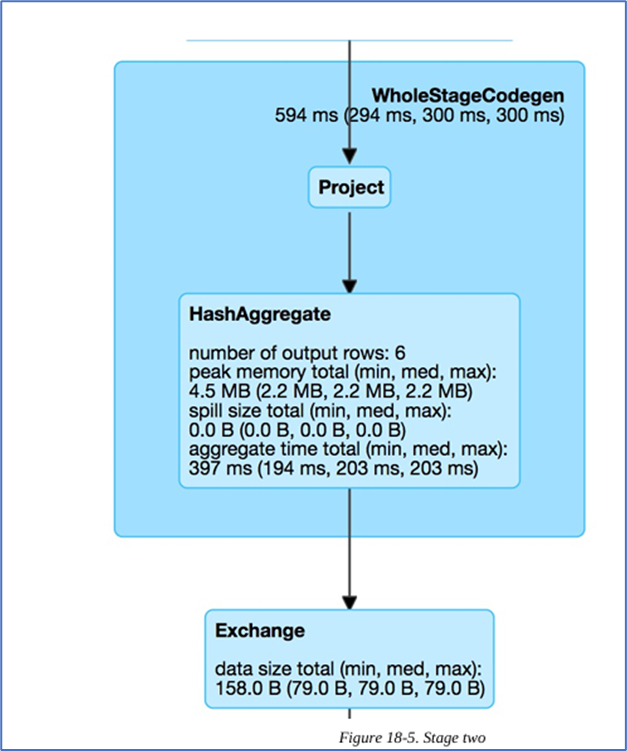

Since the dataset has 3 distinct group of data
So the HashAggregate show no of output=6 because 3 Group of data x 2 partitions

.selectExpr("instr(Description, 'GLASS') >= 1 as is_glass")\

.groupBy("is_glass")\



The last stage is the aggregation of the subaggregations that we saw happen on a per-partition basis in the previous stage.


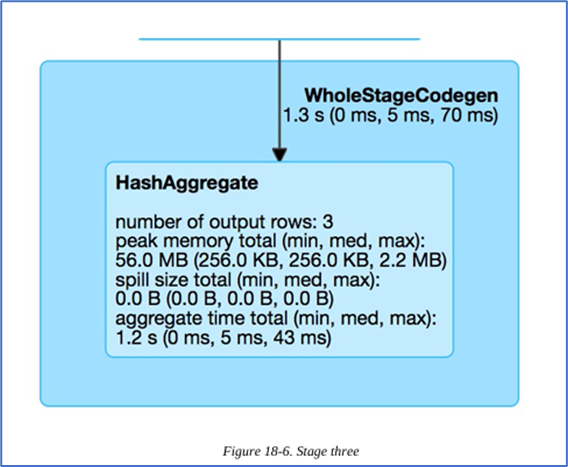

combined those two partitions in the final three rows that are the output of our total query

**Spark Tasks**

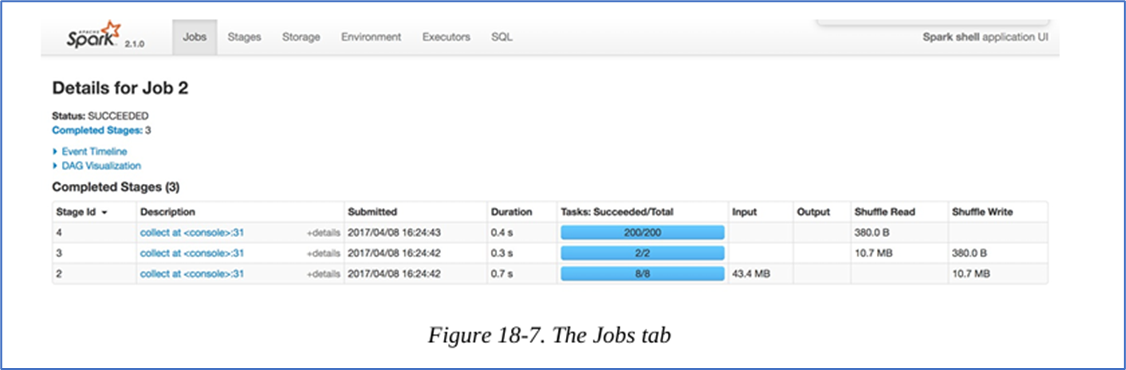

In this example, 3 stages ran, with 8,2 and then 200 tasks each

The 1st stage has 8 tasks.

CSV files are splittable, and Spark broke up the work to be distributed evenly between the different cores on the machine.
In our system the total cores is 8

Note: This happens at the cluster level and points to an important optimization - how you store your files



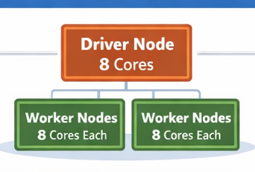

The 2nd stage has two tasks because we explicitly called a repartition to move the data into two partitions

The last stage has 200 tasks because the default shuffle partitions value is 200.

Click the stage with 8 tasks to see the next level of detail

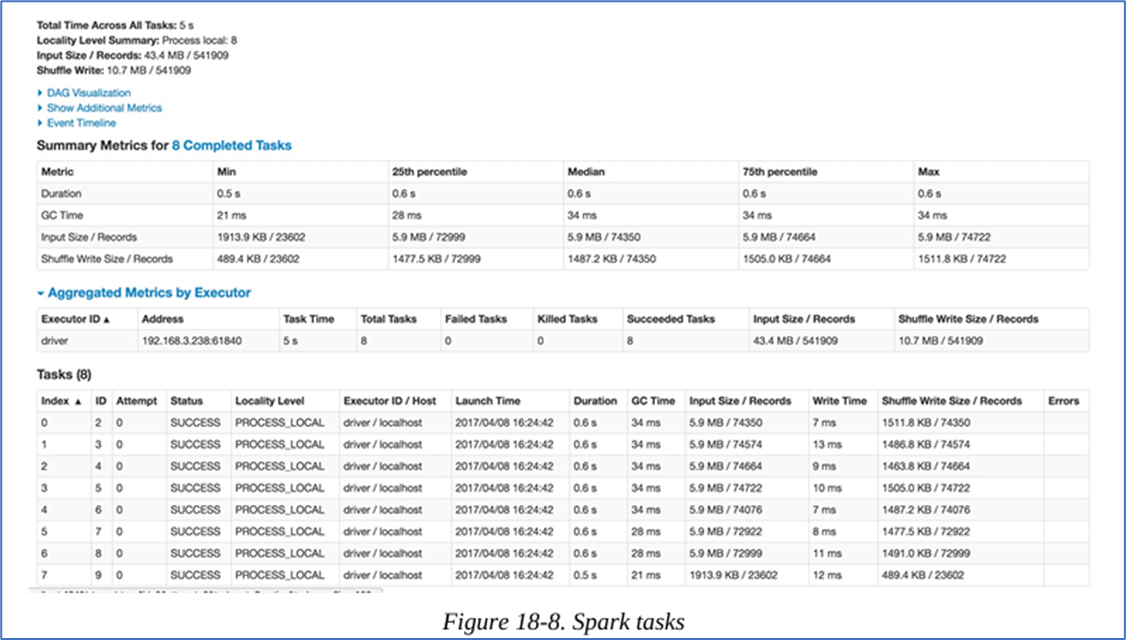

**Summary Metrics section**


Shows the data distribution across executors. This can help identify whether a particular executor is struggling with its workload.


**Spark Storage Tab**

The Storage tab shows information about the cached RDDs/DataFrames on the cluster. This can help you see if certain data has been evicted from the cache over time

**Environment tab**

The Environment tab shows the information about the Runtime Environment

Monitoring and Instrumentation - Spark 4.1.0 Documentation
https://spark.apache.org/docs/latest/monitoring.html#spark-configuration-options


The Spark UI is only available while a SparkContext is running, to see the details even after we need to configure Spark UI History Server

# Using Azure Databricks

In Azure Databricks, breaking user code into Jobs , stages and tasks is decided by Databricks itself.

Monitoring perspective what should I check

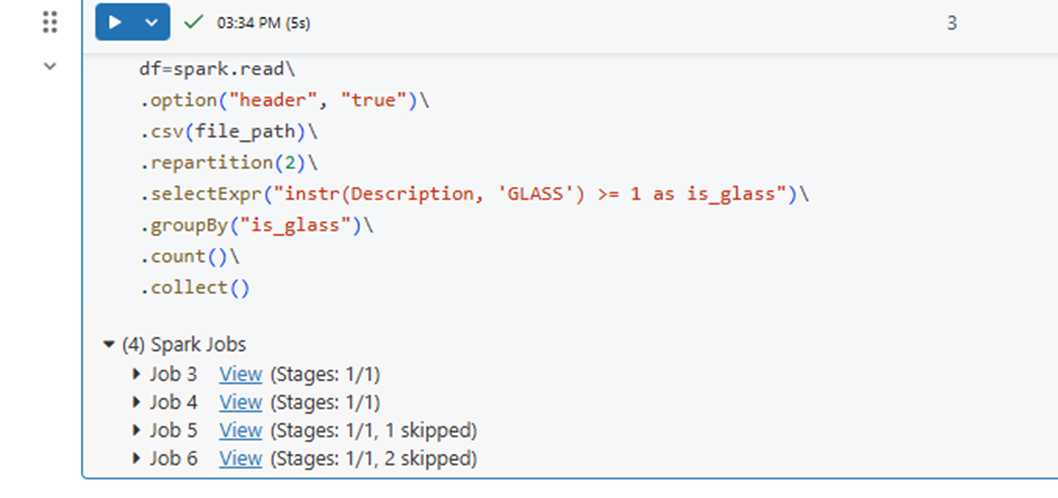

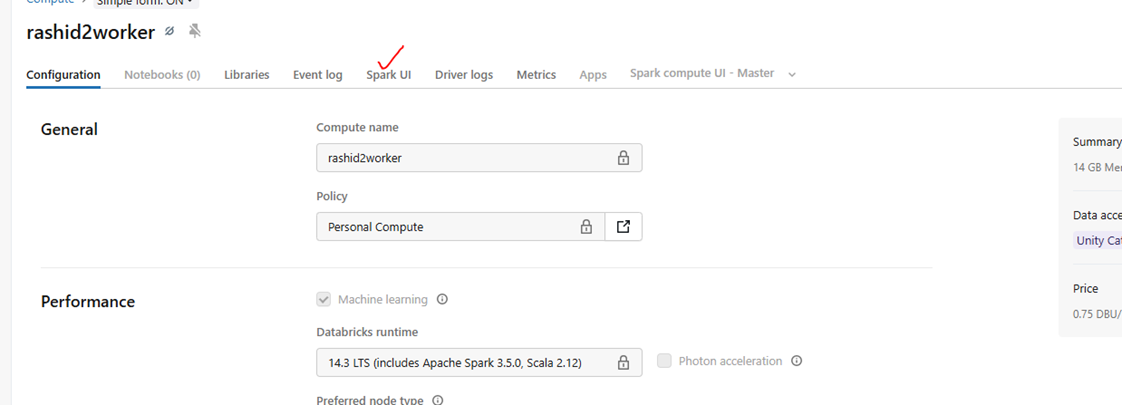

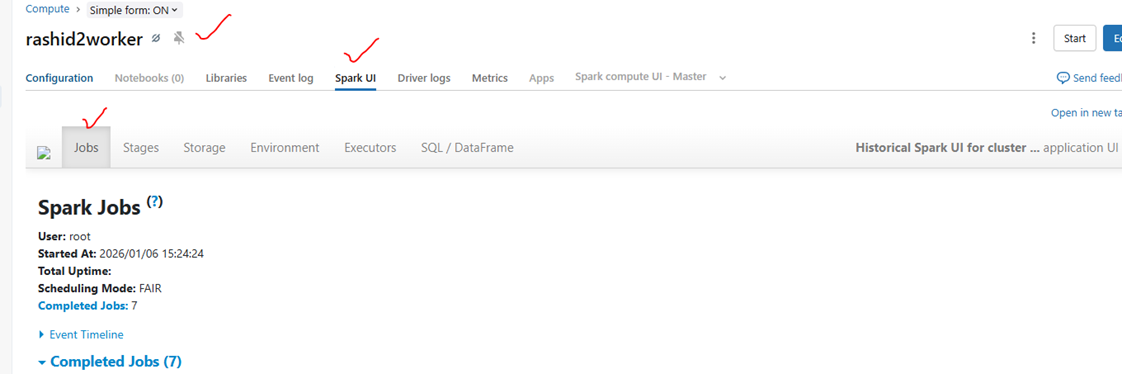

Select any particular Job

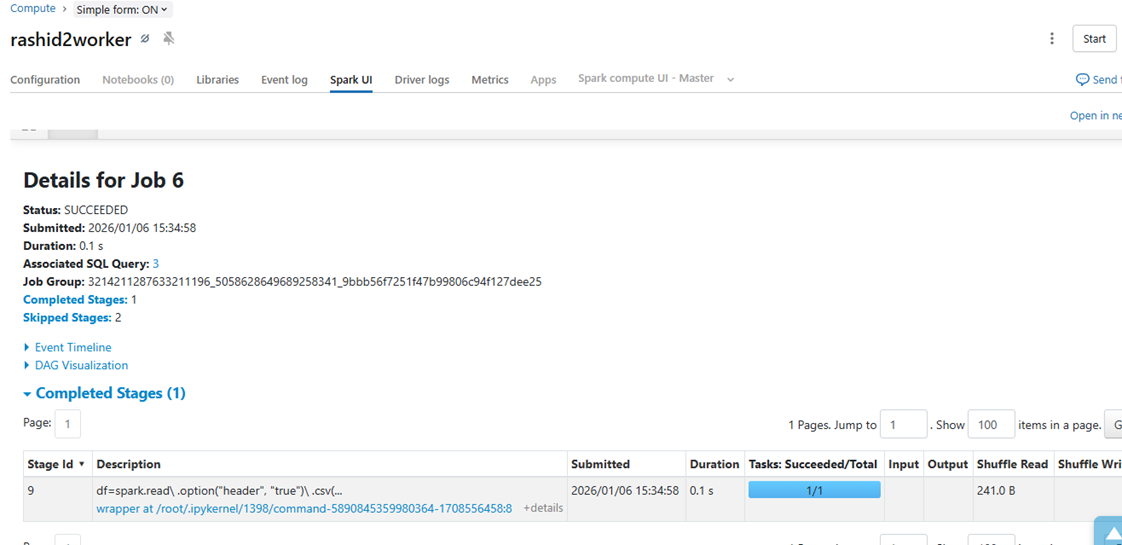

Click the Stage to see the Task(s)

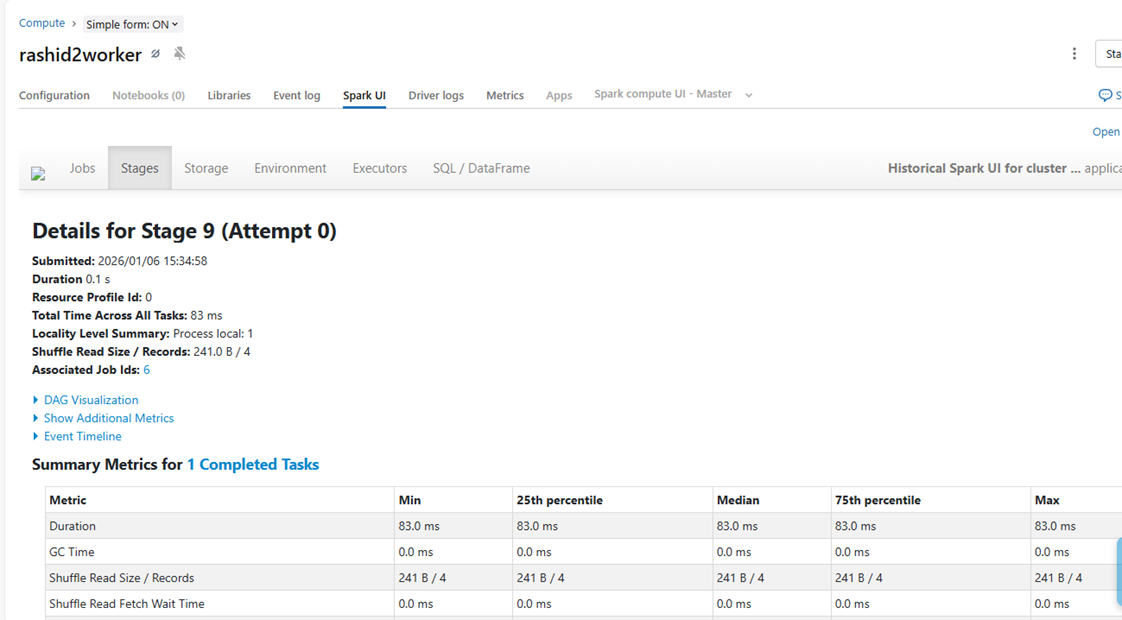

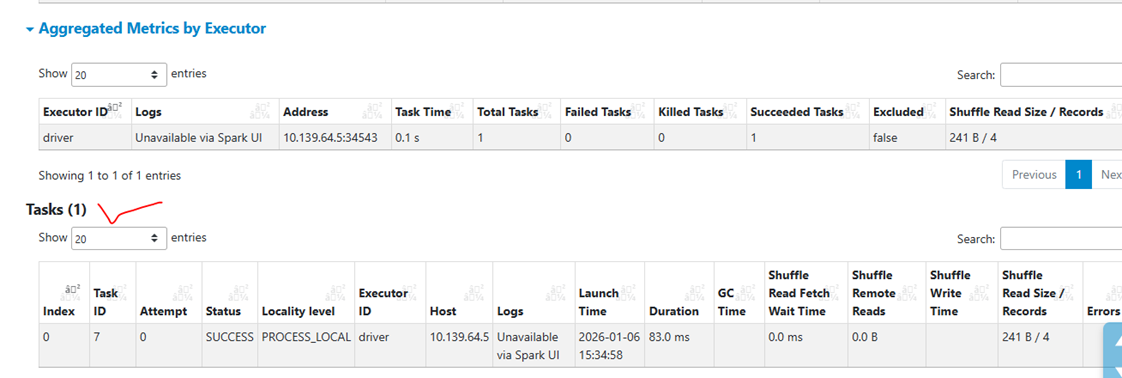

Overall jobs for this user code

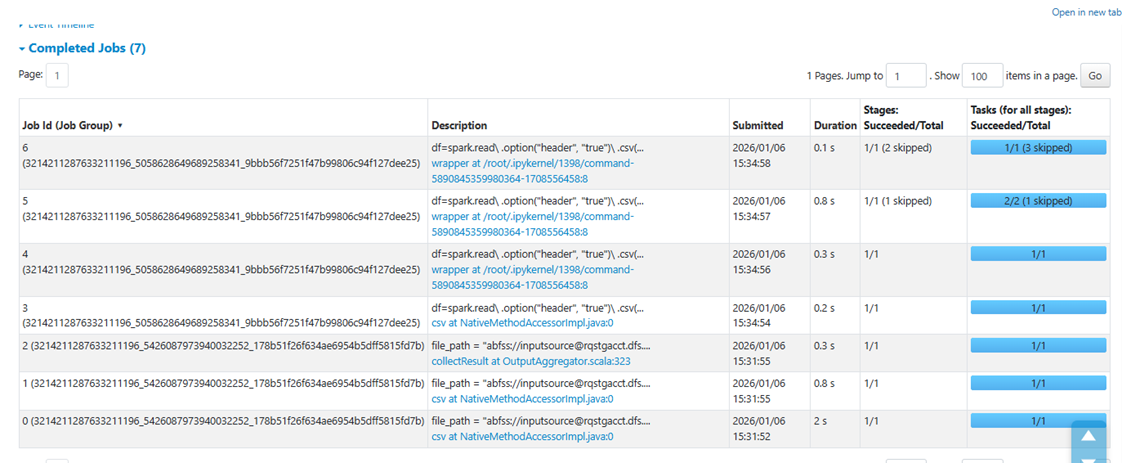

To check Query

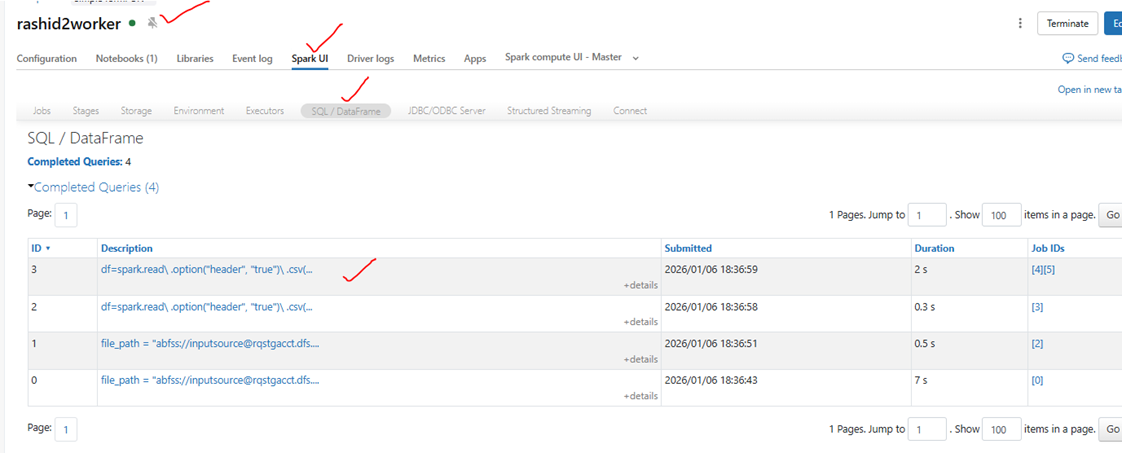

CPU Usage, Memory Usage

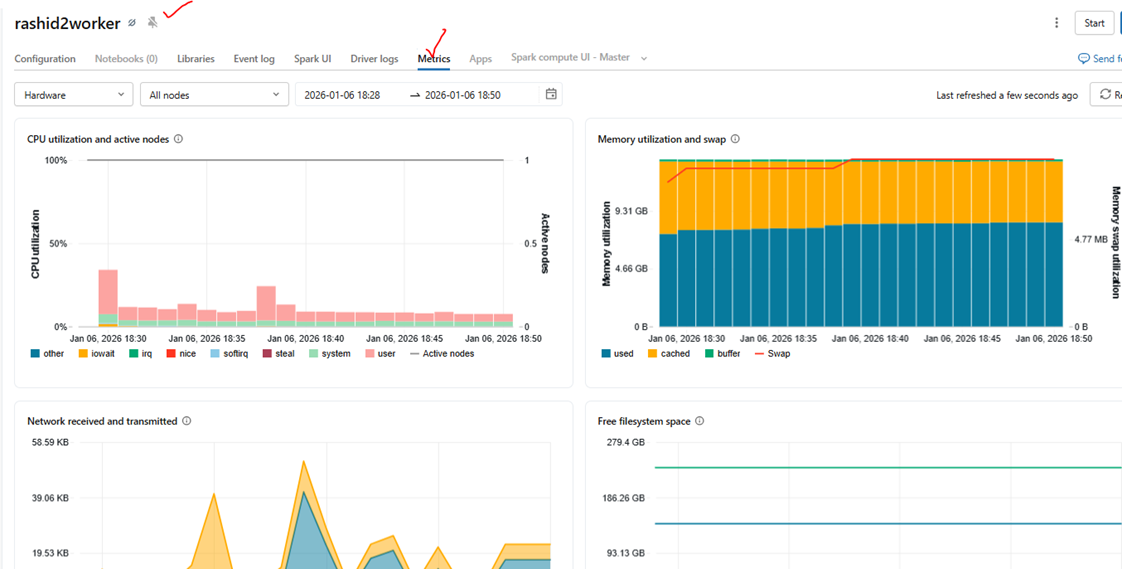

# What to look At In Azure Databricks Notebook Execution

On Azure Databricks, we don’t control how Spark breaks our code into Jobs/Stages/Tasks, but we can absolutely monitor and diagnose performance by knowing what to look at.

**1. DAG Visualization (Execution Plan)**
------------------------------------
This is your first stop.
Look for:
- Number of shuffle boundaries
- Whether Spark is doing unnecessary Exchange operations
- Whether your query is pushing filters down
- Whether there are wide transformations (groupBy, join, repartition)
This tells you why Spark created multiple stages.

**2. Stage Details → Task Metrics**
--------------------------------
This is where the real performance story lives.

Inside each Stage, check:

✔️ Task Duration Distribution
- Are tasks evenly timed?
- Or is one task taking 10× longer? → data skew

✔️ Shuffle Read / Shuffle Write
High shuffle = slow job.
If you see:
- Shuffle Read > 1 GB per task
- Shuffle Write > 500 MB per task
…you’re paying a heavy cost.

✔️ Input Size per Task
If one task reads much more data → skew or bad partitioning.

**3. Skew Detection**
------------------
Spark won’t tell you directly, but you can infer it:
- One task takes much longer
- One task reads far more data
- Shuffle read is uneven
- Stage timeline shows a “long tail”
Skew is the #1 cause of slow jobs.

**4.Cluster Utilization**
-------------------------
In the Databricks UI → Metrics → Ganglia
Check:

✔️ CPU Utilization
- If CPU < 30% → cluster is oversized
- If CPU = 100% → cluster is undersized

✔️ Memory Pressure

- If executors spill to disk → increase memory or reduce shuffle

✔️ Executor Count

- Are all executors busy?
- Or are tasks running serially?

**5.Shuffle Spill (Memory → Disk)**
--------------------------------
Inside Stage → Tasks:
Look for:
- Spill (Memory)
- Spill (Disk)
If you see disk spill, performance drops dramatically.
Fixes:
- Increase executor memory
- Increase shuffle partitions
- Reduce wide transformations
- Avoid unnecessary repartition()

**6.Adaptive Query Execution (AQE)**
---------------------------------
Databricks enables AQE by default.
Check if AQE is:
- Coalescing partitions
- Optimizing skew joins
- Reducing shuffle partitions
If AQE is not kicking in, your query may not be optimized.
